# TensorFlow Tutorial #01
# Simple Linear Model

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

This tutorial demonstrates the basic workflow of using TensorFlow with a simple linear model. After loading the so-called MNIST data-set with images of hand-written digits, we define and optimize a simple mathematical model in TensorFlow. The results are then plotted and discussed.

You should be familiar with basic linear algebra, Python and the Jupyter Notebook editor. It also helps if you have a basic understanding of Machine Learning and classification.

## Imports

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook, trange

In [2]:
# Change image sizes
matplotlib.rcParams['figure.figsize'] = [8.0, 5.5]

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [3]:
tf.__version__

'1.2.1-rc1'

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set has now been loaded and consists of 70.000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


### One-Hot Encoding

The data-set has been loaded as so-called One-Hot encoding. This means the labels have been converted from a single number to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i$'th element which is one and means the class is $i$. For example, the One-Hot encoded labels for the first 5 images in the test-set are:

In [6]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

We also need the classes as single numbers for various comparisons and performance measures, so we convert the One-Hot encoded vectors to a single number by taking the index of the highest element. Note that the word 'class' is a keyword used in Python so we need to use the name 'cls' instead.

In [7]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

We can now see the class for the first five images in the test-set. Compare these to the One-Hot encoded vectors above. For example, the class for the first image is 7, which corresponds to a One-Hot encoded vector where all elements are zero except for the element with index 7.

In [8]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4], dtype=int64)

### Data dimensions

The data dimensions are used in several places in the source-code below. In computer programming it is generally best to use variables and constants rather than having to hard-code specific numbers every time that number is used. This means the numbers only have to be changed in one single place. Ideally these would be inferred from the data that has been read, but here we just write the numbers.

In [9]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [10]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

### Plot a few images to see if data is correct

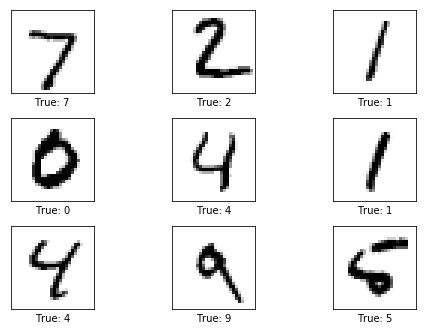

In [11]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used to change the input to the graph.
* Model variables that are going to be optimized so as to make the model perform better.
* The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables of the model.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

### Placeholder variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [12]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [13]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

Finally we have the placeholder variable for the true class of each image in the placeholder variable `x`. These are integers and the dimensionality of this placeholder variable is set to `[None]` which means the placeholder variable is a one-dimensional vector of arbitrary length.

In [14]:
y_true_cls = tf.placeholder(tf.int64, [None])

### Variables to be optimized

Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow so as to make the model perform better on the training data.

The first variable that must be optimized is called `weights` and is defined here as a TensorFlow variable that must be initialized with zeros and whose shape is `[img_size_flat, num_classes]`, so it is a 2-dimensional tensor (or matrix) with `img_size_flat` rows and `num_classes` columns.

In [15]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

The second variable that must be optimized is called `biases` and is defined as a 1-dimensional tensor (or vector) of length `num_classes`.

In [16]:
biases = tf.Variable(tf.zeros([num_classes]))

### Model

This simple mathematical model multiplies the images in the placeholder variable `x` with the `weights` and then adds the `biases`.

The result is a matrix of shape `[num_images, num_classes]` because `x` has shape `[num_images, img_size_flat]` and `weights` has shape `[img_size_flat, num_classes]`, so the multiplication of those two matrices is a matrix with shape `[num_images, num_classes]` and then the `biases` vector is added to each row of that matrix.

Note that the name `logits` is typical TensorFlow terminology, but other people may call the variable something else.

In [17]:
logits = tf.matmul(x, weights) + biases

Now `logits` is a matrix with `num_images` rows and `num_classes` columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $j$'th class.

However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the `logits` matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in `y_pred`.

In [18]:
y_pred = tf.nn.softmax(logits)

The predicted class can be calculated from the `y_pred` matrix by taking the index of the largest element in each row.

In [19]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for `weights` and `biases`. To do this we first need to know how well the model currently performs by comparing the predicted output of the model `y_pred` to the desired output `y_true`.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the `weights` and `biases` of the model.

TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the `logits` because it also calculates the softmax internally.

In [20]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [21]:
cost = tf.reduce_mean(cross_entropy)

### Optimization method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the basic form of Gradient Descent where the step-size is set to 0.5.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [22]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### Performance measures

We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image.

In [23]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [24]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [25]:
session = tf.Session()

### Initialize variables

The variables for `weights` and `biases` must be initialized before we start optimizing them.

In [26]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

There are 50.000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use Stochastic Gradient Descent which only uses a small batch of images in each iteration of the optimizer.

In [27]:
batch_size = 100

Function for performing a number of optimization iterations so as to gradually improve the `weights` and `biases` of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [28]:
def optimize(num_iterations):
    for i in tqdm_notebook(range(num_iterations), desc='Optimizing'):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

### Helper-functions to show performance

Dict with the test-set data to be used as input to the TensorFlow graph. Note that we must use the correct names for the placeholder variables in the TensorFlow graph.

In [29]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

Function for printing the classification accuracy on the test-set.

In [30]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

Function for printing and plotting the confusion matrix using scikit-learn.

In [31]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

Function for plotting examples of images from the test-set that have been mis-classified.

In [32]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot the model weights

Function for plotting the `weights` of the model. 10 images are plotted, one for each digit that the model is trained to recognize.

In [33]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

## Performance before any optimization

The accuracy on the test-set is 9.8%. This is because the model has only been initialized and not optimized at all, so it always predicts that the image shows a zero digit, as demonstrated in the plot below, and it turns out that 9.8% of the images in the test-set happens to be zero digits.

In [34]:
print_accuracy()

Accuracy on test-set: 9.8%


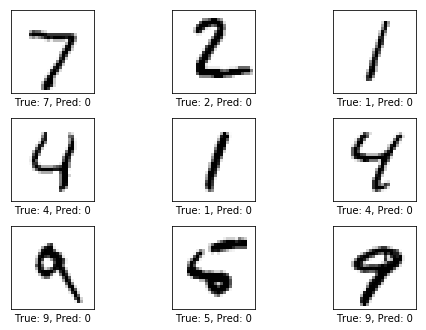

In [35]:
plot_example_errors()

## Performance after 1 optimization iteration

Already after a single optimization iteration, the model has increased its accuracy on the test-set to 40.7% up from 9.8%. This means that it mis-classifies the images about 6 out of 10 times, as demonstrated on a few examples below.

In [36]:
optimize(num_iterations=1)

In [37]:
print_accuracy()

Accuracy on test-set: 29.7%


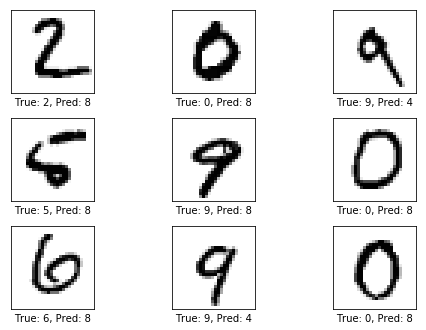

In [38]:
plot_example_errors()

The weights can also be plotted as shown below. Positive weights are red and negative weights are blue. These weights can be intuitively understood as image-filters.

For example, the weights used to determine if an image shows a zero-digit have a positive reaction (red) to an image of a circle, and  have a negative reaction (blue) to images with content in the centre of the circle.

Similarly, the weights used to determine if an image shows a one-digit react positively (red) to a vertical line in the centre of the image, and react negatively (blue) to images with content surrounding that line.

Note that the weights mostly look like the digits they're supposed to recognize. This is because only one optimization iteration has been performed so the weights are only trained on 100 images. After training on several thousand images, the weights become more difficult to interpret because they have to recognize many variations of how digits can be written.

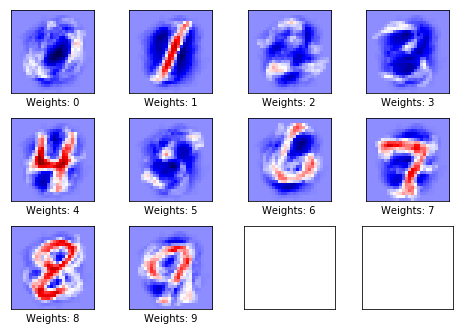

In [39]:
plot_weights()

## Performance after 10 optimization iterations

In [40]:
# We have already performed 1 iteration.
optimize(num_iterations=9)

In [41]:
print_accuracy()

Accuracy on test-set: 81.6%


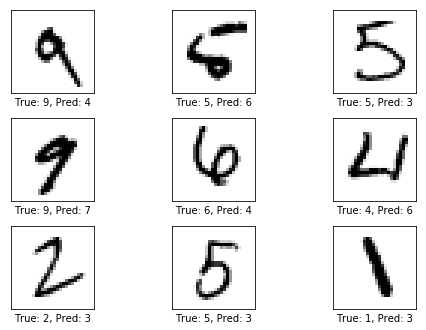

In [42]:
plot_example_errors()

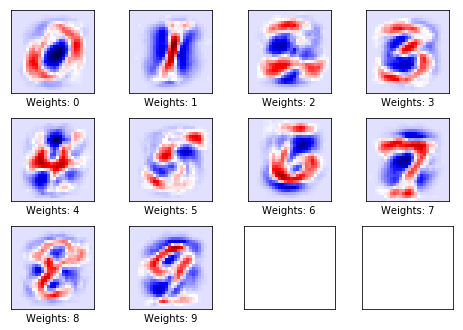

In [43]:
plot_weights()

## Performance after 1000 optimization iterations

After 1000 optimization iterations, the model only mis-classifies about one in ten images. As demonstrated below, some of the mis-classifications are justified because the images are very hard to determine with certainty even for humans, while others are quite obvious and should have been classified correctly by a good model. But this simple model cannot reach much better performance and more complex models are therefore needed.

In [44]:
# We have already performed 10 iterations.
optimize(num_iterations=990)

In [45]:
print_accuracy()

Accuracy on test-set: 92.0%


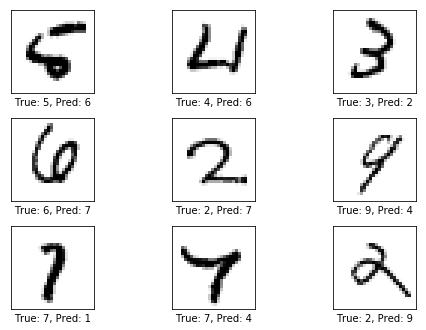

In [46]:
plot_example_errors()

The model has now been trained for 1000 optimization iterations, with each iteration using 100 images from the training-set. Because of the great variety of the images, the weights have now become difficult to interpret and we may doubt whether the model truly understands how digits are composed from lines, or whether the model has just memorized many different variations of pixels.

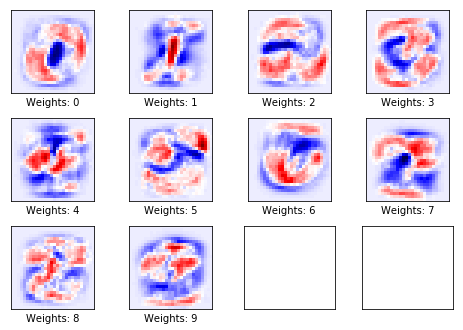

In [47]:
plot_weights()

We can also print and plot the so-called confusion matrix which lets us see more details about the mis-classifications. For example, it shows that images actually depicting a 5 have sometimes been mis-classified as all other possible digits, but mostly either 3, 6 or 8.

[[ 963    0    0    1    0    1   10    1    4    0]
 [   0 1115    2    2    0    2    4    2    8    0]
 [   9   12  894   16   15    5   15   12   46    8]
 [   3    1   12  912    1   27    2   10   34    8]
 [   1    4    2    1  921    0   11    2    8   32]
 [  12    5    2   28   12  762   17    7   41    6]
 [   9    3    3    2   10   11  911    3    6    0]
 [   3   14   19    9    8    1    0  937    3   34]
 [   6    8    4   17    9   20    8    9  890    3]
 [   9    9    1    9   44    6    1   22   13  895]]


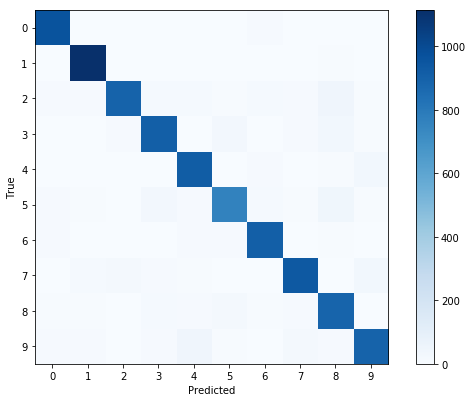

In [48]:
print_confusion_matrix()

In [49]:
optimize(num_iterations=9000)

In [50]:
print_accuracy()

Accuracy on test-set: 92.2%


We are now done using TensorFlow, so we close the session to release its resources.

In [54]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Change the learning-rate for the optimizer.
* Change the optimizer to e.g. `AdagradOptimizer` or `AdamOptimizer`.
* Change the batch-size to e.g. 1 or 1000.
* How do these changes affect the performance?
* Do you think these changes will have the same effect (if any) on other classification problems and mathematical models?
* Do you get the exact same results if you run the Notebook multiple times without changing any parameters? Why or why not?
* Change the function `plot_example_errors()` so it also prints the `logits` and `y_pred` values for the mis-classified examples.
* Use `sparse_softmax_cross_entropy_with_logits` instead of `softmax_cross_entropy_with_logits`. This may require several changes to multiple places in the source-code. Discuss the advantages and disadvantages of using the two methods.
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.